# [ LG에너지솔루션 DX Expert 양성과정 - Auto-Encoder #3]

Deep Auto-Encoder를 활용한 time-series anomaly detection

## 강의 복습
강의자료: Deep Auto-Encoder
- `RNN Auto-Encoder`: 순차 데이터를 복원하는 오토 인코더

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240702_Deep_Auto_Encoder/image/RNNAE01.png?raw=true" width="600">

## 실습 요약

1. 본 실습에서는 RNN Auto-Encoder를 활용하여 시계열 이상 탐지를 수행합니다.

---

# Import modules

In [1]:
# 데이터 처리 및 모델 학습에 필요한 라이브러리 임포트
import numpy as np                # 수치 연산을 위한 라이브러리
import pandas as pd               # 데이터 처리를 위한 라이브러리
import os                         # 운영체제와 상호작용하기 위한 라이브러리
import random                     # 난수 생성을 위한 라이브러리

import torch                      # PyTorch 라이브러리
import torch.nn as nn             # 신경망 모듈
import torch.nn.functional as F   # 신경망 함수
from torch.utils.data import Dataset, DataLoader  # 데이터셋 및 데이터로더 모듈
from torch.optim import Adam, SGD  # 옵티마이저 모듈

from sklearn.metrics import roc_auc_score  # ROC AUC 점수 계산을 위한 메트릭
from itertools import groupby, accumulate  # 반복자 함수

# 시각화 라이브러리 임포트
import matplotlib.pyplot as plt   # 데이터 시각화를 위한 라이브러리
import seaborn as sns             # 데이터 시각화를 위한 고급 라이브러리

# Seaborn의 플롯 스타일 설정
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Functions

In [2]:
def torch_seed(random_seed: int):
    """Torch 및 기타 라이브러리의 시드를 고정하여 재현성을 확보합니다."""
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)


def train(
    model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
    criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, 
    log_interval: int, device: str
) -> float:
    """모델을 학습시키고 평균 손실을 반환합니다."""

    total_loss = []

    model.train()
    for i, (inputs, _) in enumerate(dataloader):

        # convert device
        inputs = inputs.to(device)

        # model outputs
        outputs = model(inputs)

        # loss
        loss = criterion(inputs, outputs).mean()
        total_loss.append(loss.item())

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print(f"{'TRAIN':5s} [{i+1:5d}/{len(dataloader):5d}] loss: {np.mean(total_loss):.4f}")

    # average loss
    avg_loss = np.mean(total_loss)

    return avg_loss

def test(
    model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
    criterion: torch.nn.Module, log_interval: int, device: str
) -> tuple:
    """모델을 평가하고 AUROC 점수 및 예측 결과를 반환합니다."""

    # for auroc
    total_loss = []
    total_inputs = []
    total_targets = []
    total_outputs = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            # get inputs and targets
            total_inputs.extend(inputs.numpy())
            total_targets.extend(targets.numpy())

            # convert device
            inputs = inputs.to(device)

            # model outputs
            outputs = model(inputs)
            total_outputs.extend(outputs.cpu().numpy())

            # loss
            loss = criterion(inputs, outputs).max(dim=-1)[0]
            total_loss.extend(loss.cpu().numpy())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print(f"{'TSET':5s} [{i+1:5d}/{len(dataloader):5d}] loss: {np.mean(total_loss):.4f}")

    # total inputs, outputs, targets and loss
    total_inputs = np.concatenate(total_inputs, axis=0)
    total_outputs = np.concatenate(total_outputs, axis=0)
    total_targets = np.array(total_targets).reshape(-1)
    total_loss = np.array(total_loss).reshape(-1)

    # auroc
    if sum(total_targets) == 0:
        auroc = 1.
    else:
        auroc = roc_auc_score(total_targets, total_loss)

    # return
    return auroc, total_inputs, total_outputs, total_loss


def fit(
    model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, 
    testloader: torch.utils.data.DataLoader, criterion: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, epochs: int, log_interval: int, 
    device: str
) -> tuple:
    """모델을 학습하고 테스트하여 학습 손실 및 테스트 AUROC 히스토리를 반환합니다."""

    train_history = []
    test_history_auroc = []

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_loss = train(
            model        = model,
            dataloader   = trainloader,
            criterion    = criterion,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device
        )

        test_auroc, total_inputs, total_outputs, total_loss = test(
            model        = model,
            dataloader   = testloader,
            criterion    = criterion,
            log_interval = log_interval,
            device       = device
        )

        print(f'\nTest AUROC: {test_auroc:.4f}')

        # show results
        plt.figure(figsize=(15,4))
        sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:,0], label='inputs')
        sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:,0], label='reconstruction')
        sns.lineplot(x=range(len(total_loss)), y=total_loss, label='anomaly score')

        # set title
        plt.title("testset anomal score")
        plt.xlabel("time index")
        plt.ylabel("value")
        plt.tight_layout()
        plt.show()

        # stack history
        train_history.append(train_loss)
        test_history_auroc.append(test_auroc)

    return train_history, test_history_auroc


def figure(
    all_train_history: list, all_test_history_auroc: list, all_exp_name: list
) -> None:
    """학습 손실 및 테스트 AUROC 히스토리를 시각화합니다."""

    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    # train line plot
    for i, (train_h, exp_name) in enumerate(zip(all_train_history, all_exp_name)):
        sns.lineplot(
            x     = range(1, len(train_h)+1),
            y     = train_h,
            label = exp_name,
            ax    = ax[0]
        )

    # test AUROC lineplot
    for i, (test_h, exp_name) in enumerate(zip(all_test_history_auroc, all_exp_name)):
        sns.lineplot(
            x     = range(1, len(test_h)+1),
            y     = test_h,
            label = exp_name,
            ax    = ax[1]
        )


    # set y axis label
    ax[0].set_ylabel('MSE Loss')
    ax[1].set_ylabel('AUROC')

    # set x axis label
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    # set title
    ax[0].set_title('Train loss history')
    ax[1].set_title('Test AUROC(image-level) history')

    # set y value limit
    max_train = np.max(all_train_history)

    ax[0].set_ylim(0, max_train+0.01)
    ax[1].set_ylim(0, 1)

    # set legend
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Configuration for experiments

In [3]:
class Config:
    """
    실험 설정을 담고 있는 클래스
    """

    # dataset 관련 parameters
    window = 100        # 윈도우 크기 (시계열 데이터의 한 구간 크기)
    stride = 10         # 스트라이드 크기 (윈도우가 이동하는 간격)

    # make dataset
    sin_sequence = 100  # 사인 곡선 시퀀스 길이
    repeat = 30         # 사인 곡선을 반복할 횟수

    # synthesis anomaly setting
    anomaly_sequence = 10  # 이상치 시퀀스 길이
    anomaly_region = 5     # 이상치 영역 크기

    # training 관련 parameters
    epochs = 20            # 총 학습 에폭 수
    batch_size = 8         # 학습 데이터 배치 크기
    test_batch_size = 128  # 테스트 데이터 배치 크기
    learning_rate = 0.001  # 학습률
    num_workers = 2        # 데이터 로딩을 위한 워커 수
    log_interval = 2000    # 로그 출력 간격

    # device
    device = 'cuda'        # 학습을 위한 디바이스 (cuda 또는 cpu)

    # seed
    seed = 223             # 시드 값 (재현성 확보를 위해 고정)

# Config 클래스의 인스턴스를 생성
cfg = Config()

## make dataset

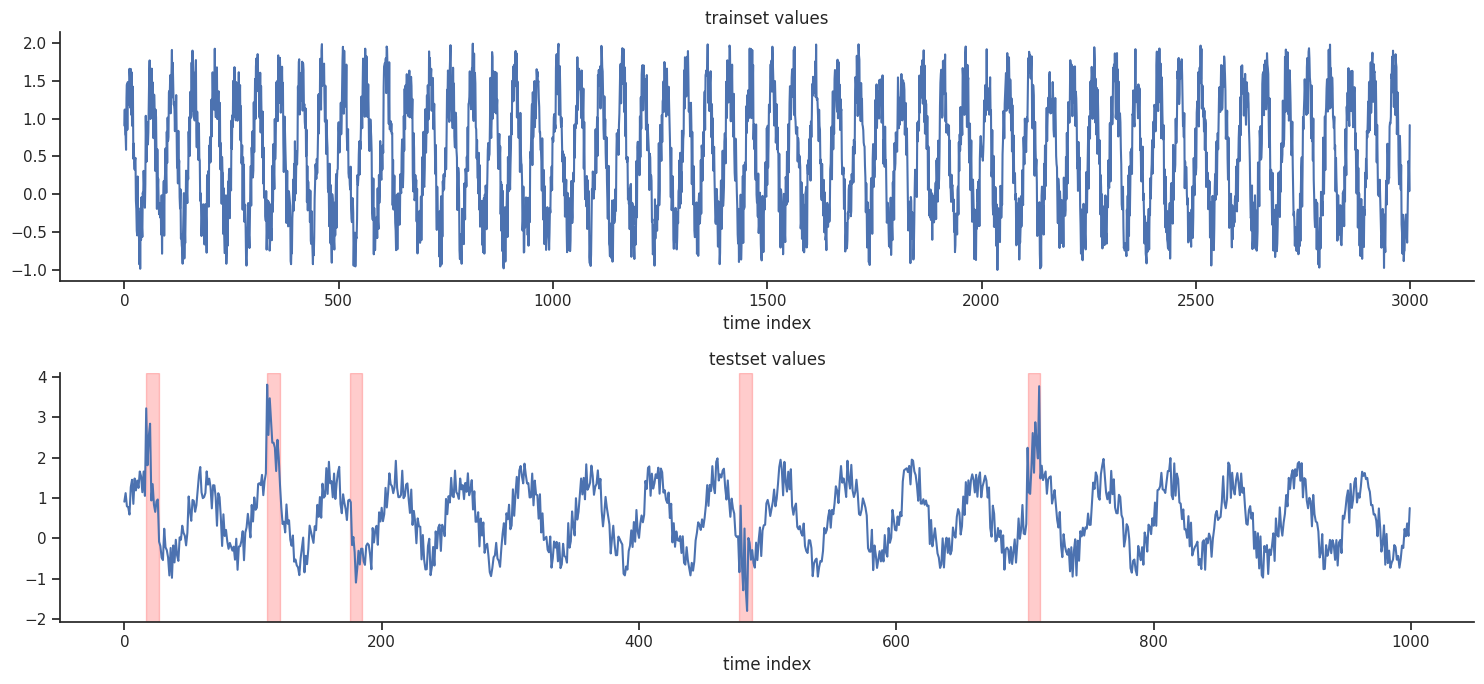

In [4]:
# 학습 데이터셋 생성
x_train = np.array([np.sin(i * np.pi) for i in np.linspace(start=-2, stop=2, num=cfg.sin_sequence)] * cfg.repeat)
x_train = x_train + np.random.random(cfg.sin_sequence * cfg.repeat)  # 노이즈 추가
y_train = np.zeros(len(x_train))  # 학습 데이터셋 레이블 (모두 정상)

# 테스트 데이터셋 생성
x_test = x_train[:1000].copy()  # 학습 데이터셋의 일부를 복사하여 테스트 데이터셋 생성
y_test = np.zeros(len(x_test))  # 테스트 데이터셋 레이블 (모두 정상)

# 시드 설정
torch_seed(cfg.seed)

# 이상치 인덱스 선택
anomaly_idx = np.random.choice(range(len(x_test)), size=cfg.anomaly_region)

# 이상치 삽입
for ano_idx in anomaly_idx:
    x_test[ano_idx:ano_idx + cfg.anomaly_sequence] = x_test[ano_idx:ano_idx + cfg.anomaly_sequence] * 2  # 이상치 삽입
    y_test[ano_idx:ano_idx + cfg.anomaly_sequence] = 1  # 이상치 레이블 설정

# 데이터셋 시각화
fig, ax = plt.subplots(2, 1, figsize=(15, 7))

# 학습 데이터셋 시각화
sns.lineplot(x=range(len(x_train)), y=x_train, ax=ax[0])
ax[0].set_title('trainset values')
ax[0].set_xlabel('time index')

# 테스트 데이터셋 시각화
sns.lineplot(x=range(len(x_test)), y=x_test, ax=ax[1])
for ano_idx in anomaly_idx:
    ax[1].axvspan(ano_idx, ano_idx + cfg.anomaly_sequence, color='red', alpha=0.2)  # 이상치 영역 강조
ax[1].set_title('testset values')
ax[1].set_xlabel('time index')

plt.tight_layout()
plt.show()

In [6]:
class TSADDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, window: int, stride: int):
        """
        TSADDataset 클래스 초기화
        :param X: 입력 데이터 (numpy 배열)
        :param y: 타겟 레이블 (numpy 배열)
        :param window: 윈도우 크기
        :param stride: 스트라이드 크기
        """
        self.X = X
        self.y = y

        self.window = window
        self.stride = stride

        # 시작 인덱스 리스트 생성
        self.start_index = list(range(0, len(self.X) - window + 1, stride))

    def __getitem__(self, idx):
        """
        데이터셋에서 하나의 샘플을 가져옵니다.
        :param idx: 샘플 인덱스
        :return: 입력 데이터와 타겟 레이블
        """
        # 시작 인덱스 설정
        s_idx = self.start_index[idx]

        # 입력 데이터와 타겟 레이블 설정
        input = self.X[s_idx:s_idx + self.window]
        target = self.y[s_idx:s_idx + self.window]

        # 입력 데이터를 FloatTensor로 변환하고, 마지막 차원에 채널 차원 추가
        input = torch.FloatTensor(input).unsqueeze(-1)

        return input, target

    def __len__(self):
        """
        데이터셋의 샘플 수를 반환합니다.
        :return: 데이터셋 샘플 수
        """
        return len(self.start_index)

In [7]:
import torch
from torch.utils.data import DataLoader

# 학습 데이터셋 정의
trainset = TSADDataset(
    X=x_train,         # 학습 입력 데이터
    y=y_train,         # 학습 타겟 레이블
    window=cfg.window, # 윈도우 크기
    stride=cfg.stride  # 스트라이드 크기
)

# 테스트 데이터셋 정의
testset = TSADDataset(
    X=x_test,          # 테스트 입력 데이터
    y=y_test,          # 테스트 타겟 레이블
    window=cfg.window, # 윈도우 크기
    stride=cfg.window  # 스트라이드 크기 (이 설정으로 전체 윈도우가 겹치지 않음)
)

# 학습 데이터로더 정의
trainloader = DataLoader(
    trainset,                      # 학습 데이터셋
    batch_size=cfg.batch_size,     # 배치 크기
    shuffle=True,                  # 데이터 순서 섞기 여부
    num_workers=cfg.num_workers    # 데이터 로딩을 위한 워커 수
)

# 테스트 데이터로더 정의
testloader = DataLoader(
    testset,                       # 테스트 데이터셋
    batch_size=cfg.test_batch_size,# 배치 크기
    shuffle=False,                 # 데이터 순서 섞지 않기
    num_workers=cfg.num_workers    # 데이터 로딩을 위한 워커 수
)

# RNN Auto-Encoder

In [8]:
class RNNAutoEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int, num_layers: int):
        """
        RNNAutoEncoder 클래스 초기화
        :param input_dim: 입력 차원
        :param hidden_size: RNN의 은닉 상태 크기
        :param num_layers: RNN의 레이어 수
        """
        super(RNNAutoEncoder, self).__init__()

        # 인코더
        self.enc = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # 디코더
        self.dec = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # 출력 레이어
        self.output = nn.Linear(in_features=hidden_size, out_features=input_dim)

    def encoder(self, x):
        """
        인코더 함수
        :param x: 입력 데이터
        :return: 인코더 출력 및 은닉 상태
        """
        out, hidden = self.enc(x)
        return out, hidden

    def decoder(self, x, hidden):
        """
        디코더 함수
        :param x: 입력 데이터
        :param hidden: 인코더의 은닉 상태
        :return: 디코더 출력 및 은닉 상태
        """
        out, hidden = self.dec(x, hidden)
        out = self.output(out)
        return out, hidden

    def forward(self, x):
        """
        순전파 함수
        :param x: 입력 데이터
        :return: 재구성된 출력
        """
        batch_size, seq_len, dims = x.size()

        # 인코더
        out, hidden = self.encoder(x)

        # 디코더
        x_rec = torch.zeros_like(x).to(x.device)
        x_dec = torch.zeros((batch_size, 1, dims), dtype=torch.float).to(x.device)
        for i in range(seq_len):
            out_dec_i, hidden = self.decoder(x_dec, hidden)
            x_rec[:, i, :] = out_dec_i[:, 0, :]
            x_dec = out_dec_i

        return x_rec

In [9]:
# 시드 설정
torch_seed(cfg.seed)

# RNN AutoEncoder 모델 생성
rae = RNNAutoEncoder(input_dim=1, hidden_size=32, num_layers=2)

# 모델을 지정된 장치(CPU 또는 GPU)로 이동
rae.to(cfg.device)

# 모델 로드 메시지 출력
print('Load RNN Auto-Encoder')

# 모델 파라미터의 총 개수를 출력
print('The number of model parameters: ', sum(p.numel() for p in rae.parameters()))

# 손실 함수 설정
# MSELoss (Mean Squared Error Loss) 함수를 사용하며, reduction을 'none'으로 설정하여 개별 손실 값을 유지
criterion = nn.MSELoss(reduction='none')

# 옵티마이저 설정
# Adam 옵티마이저를 사용하며, 학습률은 cfg에서 설정된 learning_rate를 사용
optimizer = Adam(rae.parameters(), lr=cfg.learning_rate)

Load RNN Auto-Encoder
The number of model parameters:  6497



Epoch: [1/20]
TRAIN [    1/   37] loss: 0.7776
TRAIN [   37/   37] loss: 0.6070
TSET  [    1/    1] loss: 0.6663

Test AUROC: 0.7556


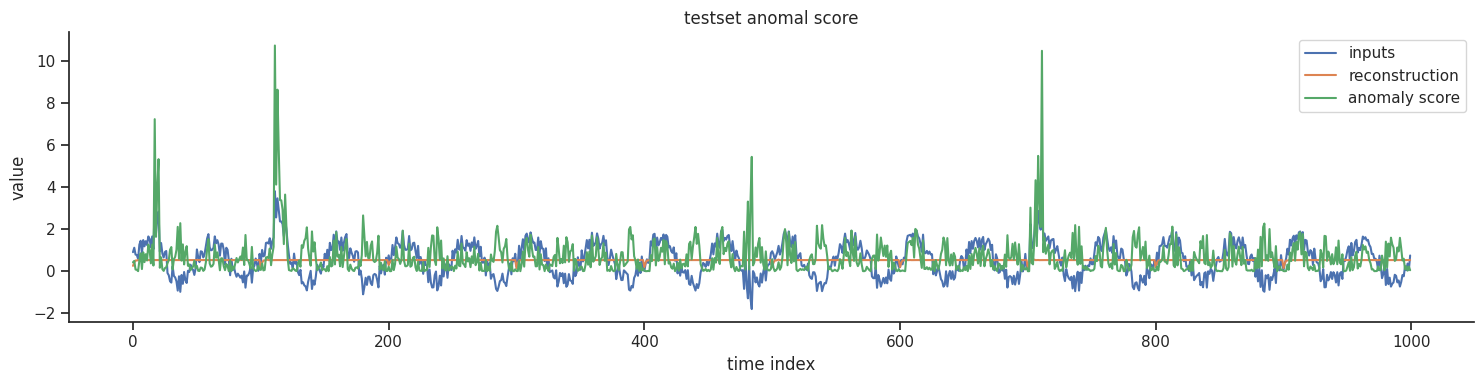


Epoch: [2/20]
TRAIN [    1/   37] loss: 0.5802
TRAIN [   37/   37] loss: 0.5759
TSET  [    1/    1] loss: 0.6664

Test AUROC: 0.7565


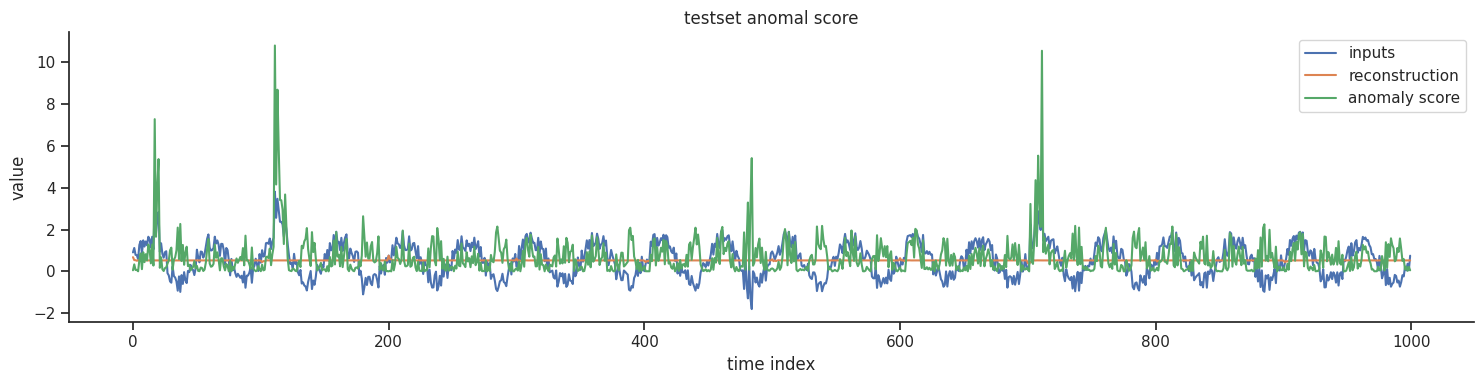


Epoch: [3/20]
TRAIN [    1/   37] loss: 0.5712
TRAIN [   37/   37] loss: 0.5620
TSET  [    1/    1] loss: 0.6492

Test AUROC: 0.7398


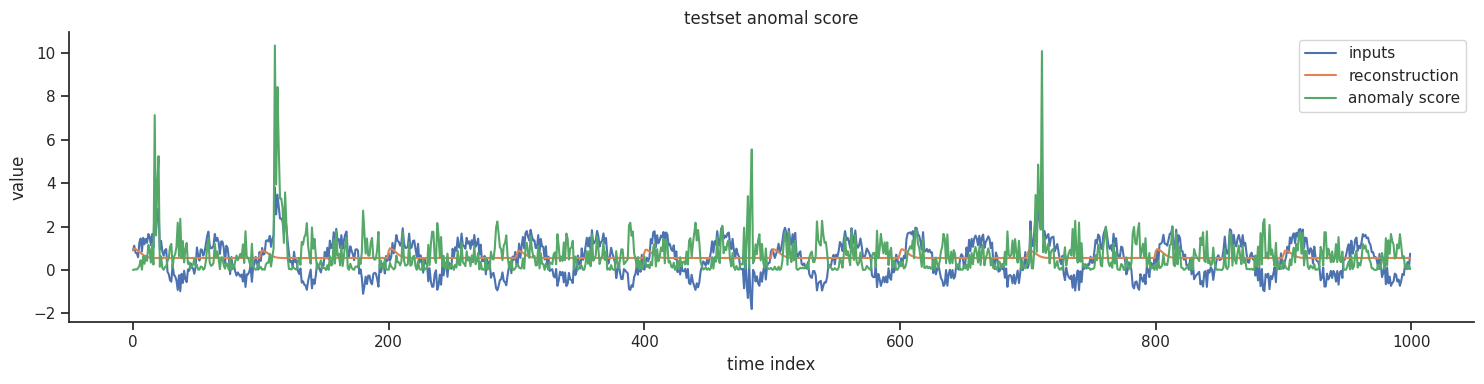


Epoch: [4/20]
TRAIN [    1/   37] loss: 0.5514
TRAIN [   37/   37] loss: 0.5303
TSET  [    1/    1] loss: 0.4735

Test AUROC: 0.7620


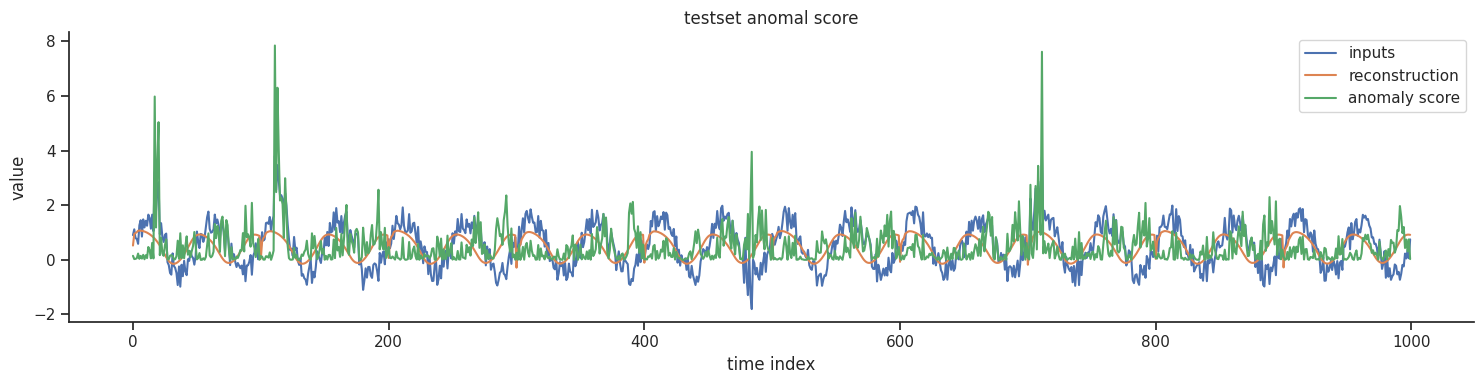


Epoch: [5/20]
TRAIN [    1/   37] loss: 0.4103
TRAIN [   37/   37] loss: 0.3397
TSET  [    1/    1] loss: 0.2004

Test AUROC: 0.7778


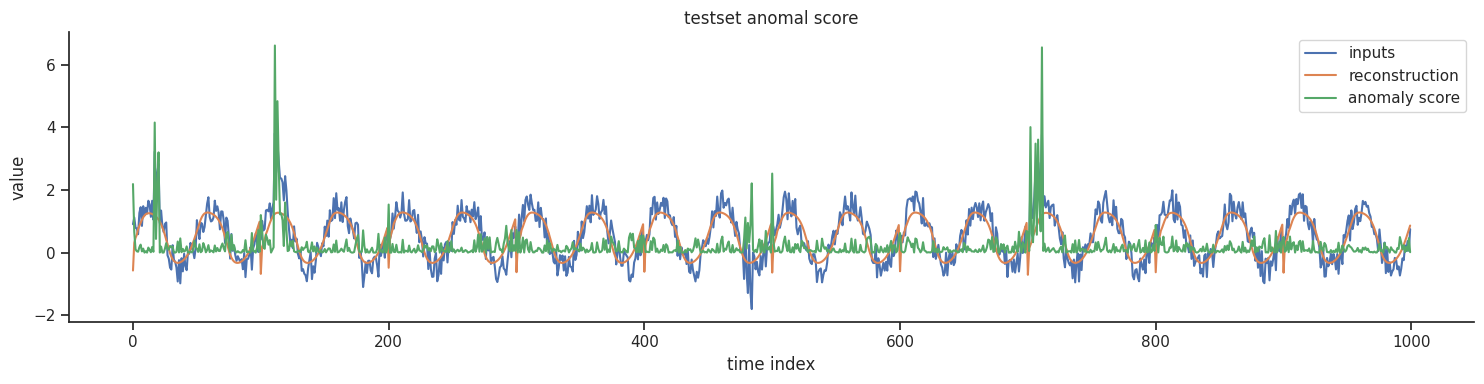


Epoch: [6/20]
TRAIN [    1/   37] loss: 0.2580
TRAIN [   37/   37] loss: 0.1887
TSET  [    1/    1] loss: 0.2065

Test AUROC: 0.7860


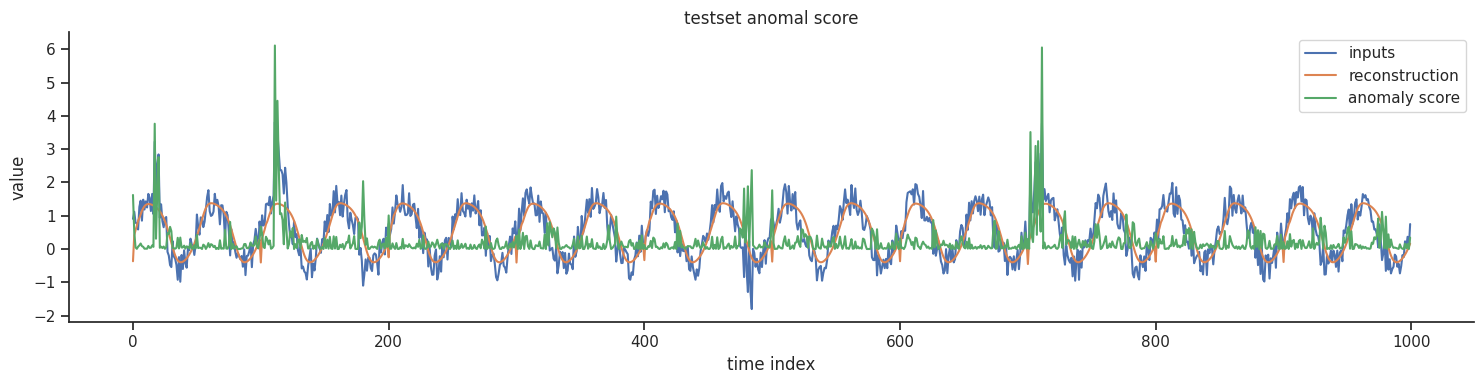


Epoch: [7/20]
TRAIN [    1/   37] loss: 0.1794
TRAIN [   37/   37] loss: 0.1290
TSET  [    1/    1] loss: 0.1388

Test AUROC: 0.8160


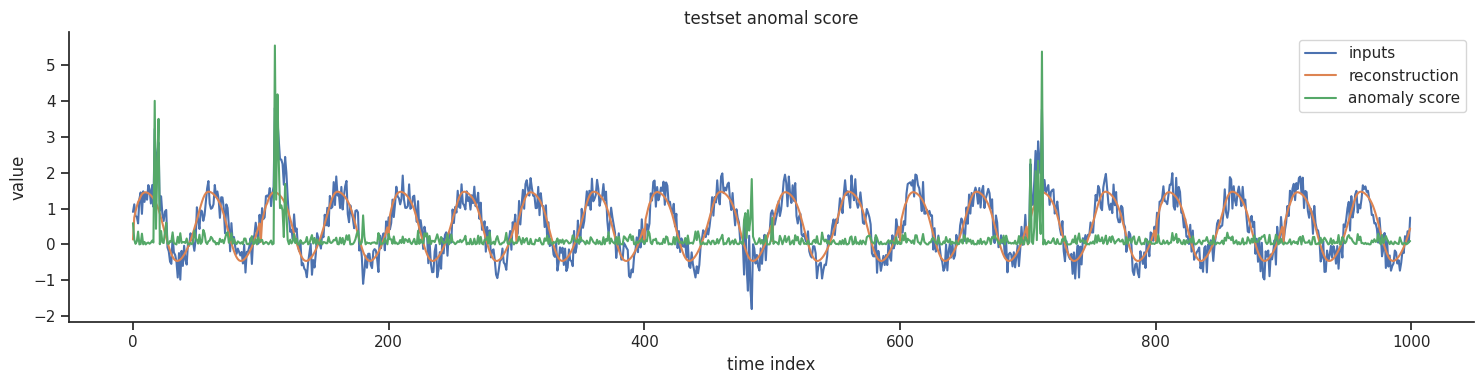


Epoch: [8/20]
TRAIN [    1/   37] loss: 0.1216
TRAIN [   37/   37] loss: 0.1094
TSET  [    1/    1] loss: 0.1353

Test AUROC: 0.8179


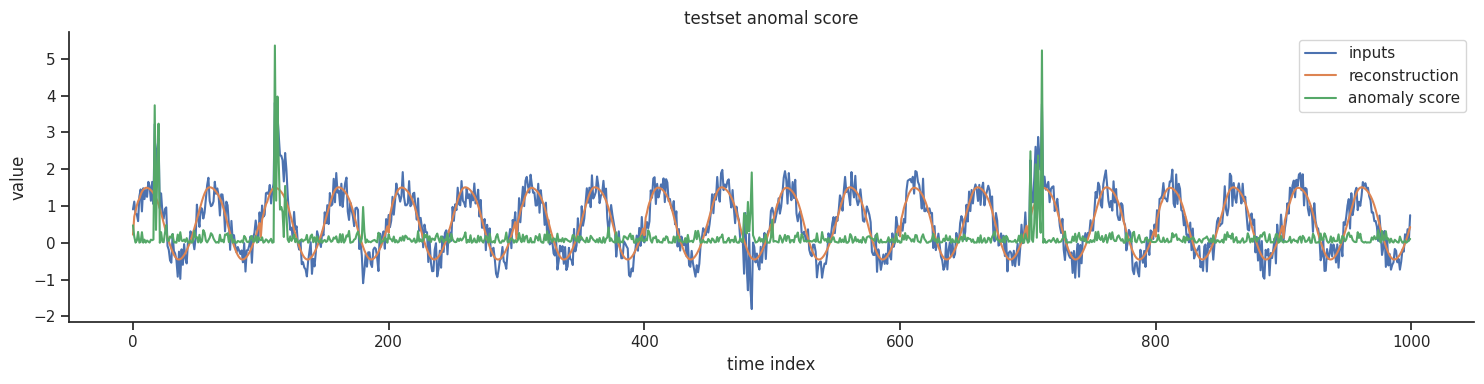


Epoch: [9/20]
TRAIN [    1/   37] loss: 0.1118
TRAIN [   37/   37] loss: 0.1004
TSET  [    1/    1] loss: 0.1355

Test AUROC: 0.8197


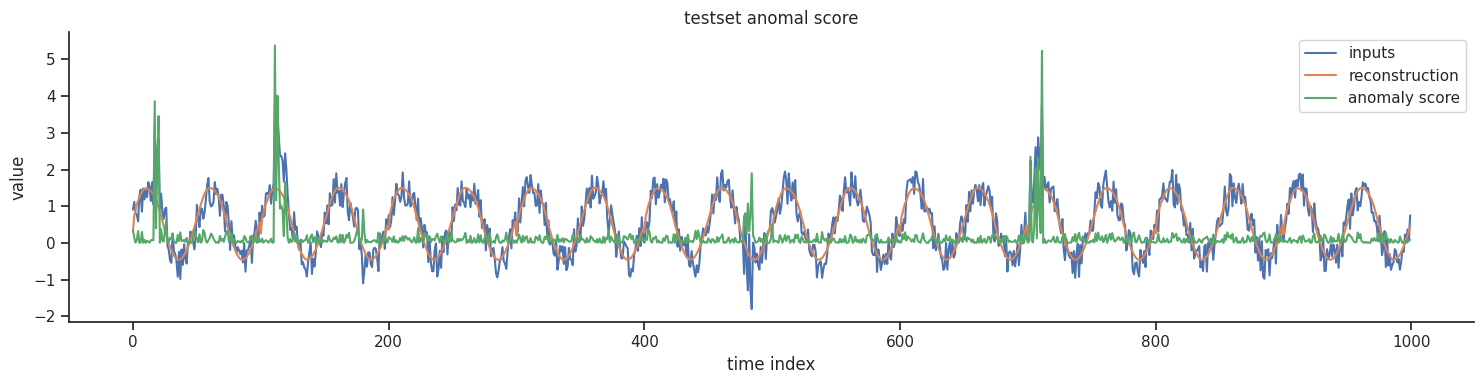


Epoch: [10/20]
TRAIN [    1/   37] loss: 0.1010
TRAIN [   37/   37] loss: 0.0988
TSET  [    1/    1] loss: 0.1357

Test AUROC: 0.8199


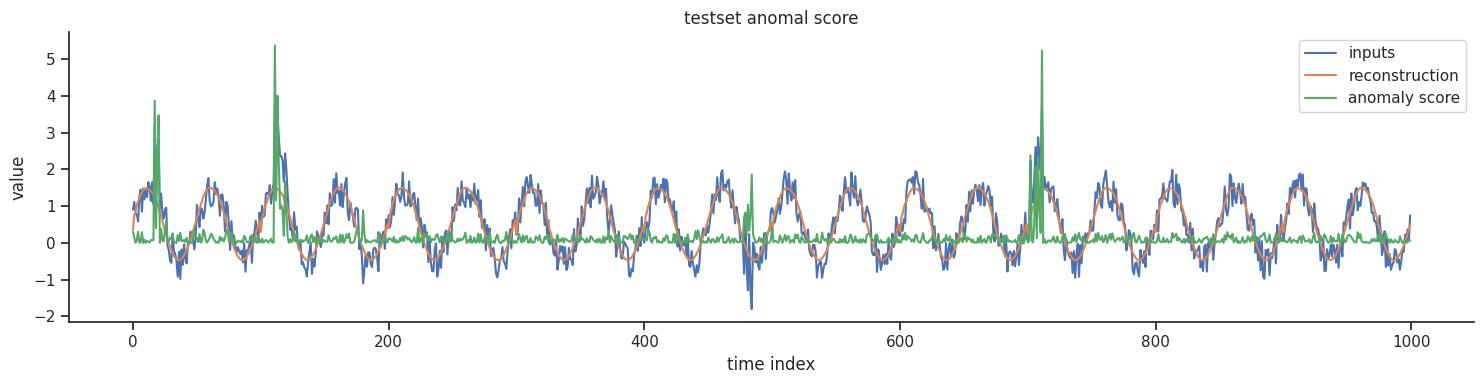


Epoch: [11/20]
TRAIN [    1/   37] loss: 0.1013
TRAIN [   37/   37] loss: 0.0974
TSET  [    1/    1] loss: 0.1366

Test AUROC: 0.8196


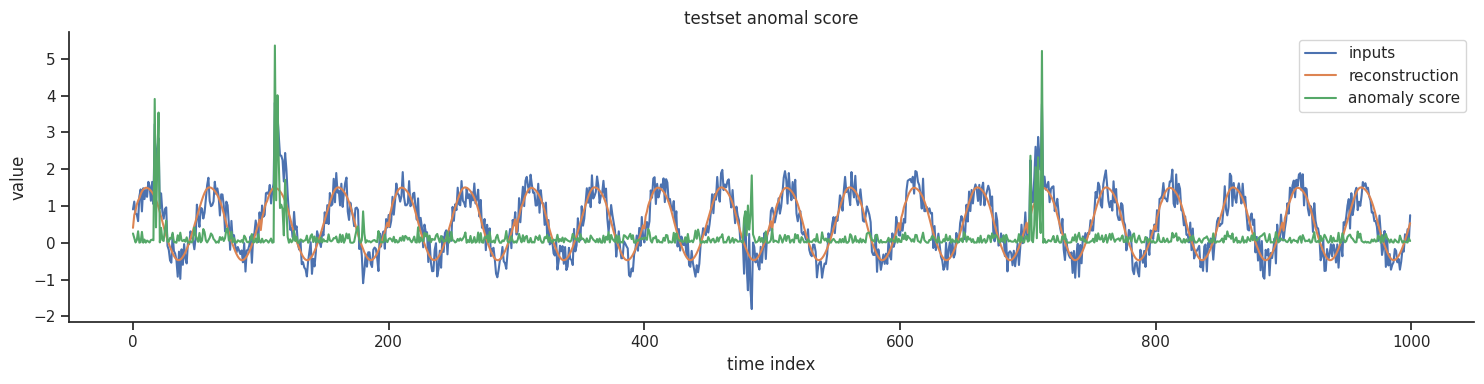


Epoch: [12/20]
TRAIN [    1/   37] loss: 0.1009
TRAIN [   37/   37] loss: 0.0963
TSET  [    1/    1] loss: 0.1379

Test AUROC: 0.8183


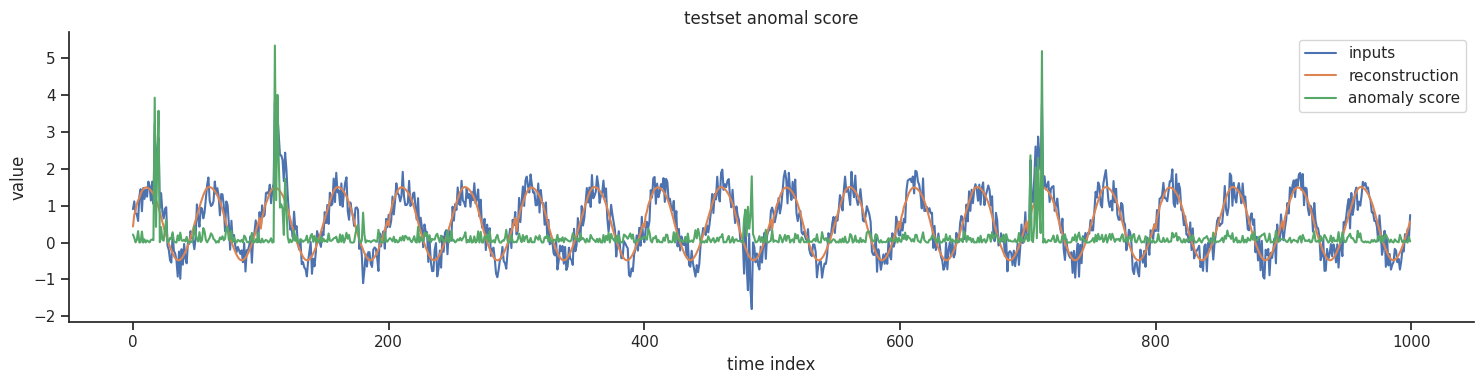


Epoch: [13/20]
TRAIN [    1/   37] loss: 0.1017
TRAIN [   37/   37] loss: 0.0954
TSET  [    1/    1] loss: 0.1393

Test AUROC: 0.8166


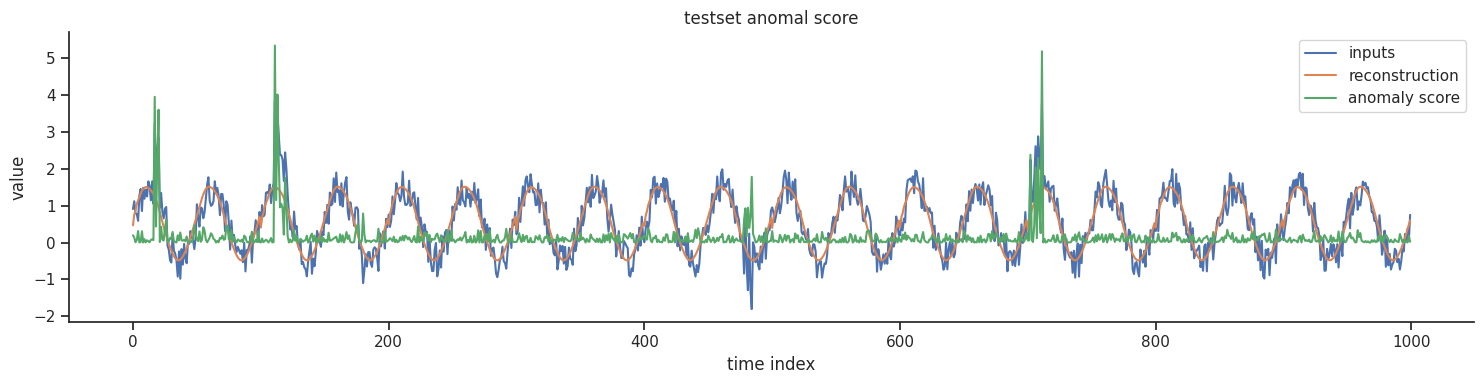


Epoch: [14/20]
TRAIN [    1/   37] loss: 0.1029
TRAIN [   37/   37] loss: 0.0947
TSET  [    1/    1] loss: 0.1394

Test AUROC: 0.8160


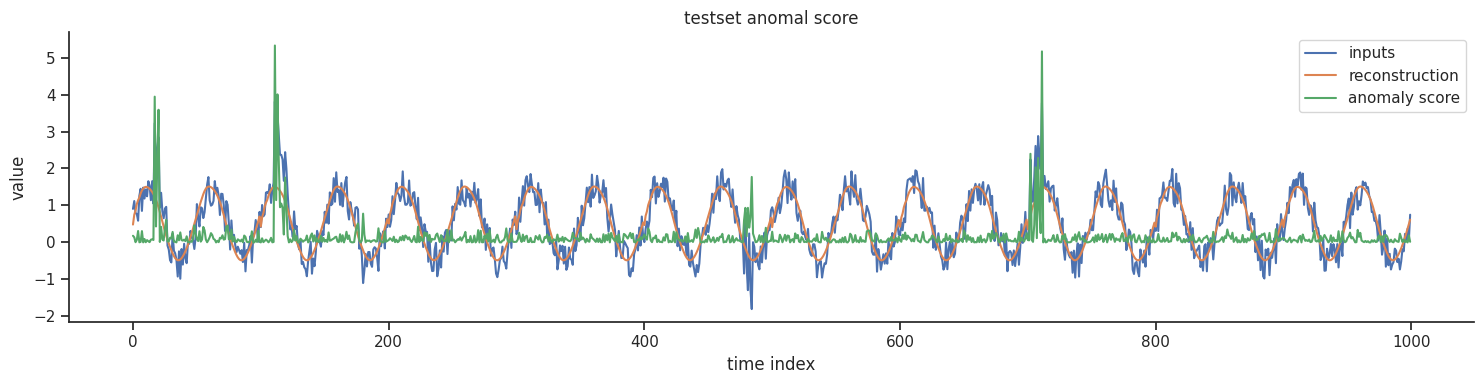


Epoch: [15/20]
TRAIN [    1/   37] loss: 0.1035
TRAIN [   37/   37] loss: 0.0939
TSET  [    1/    1] loss: 0.1381

Test AUROC: 0.8156


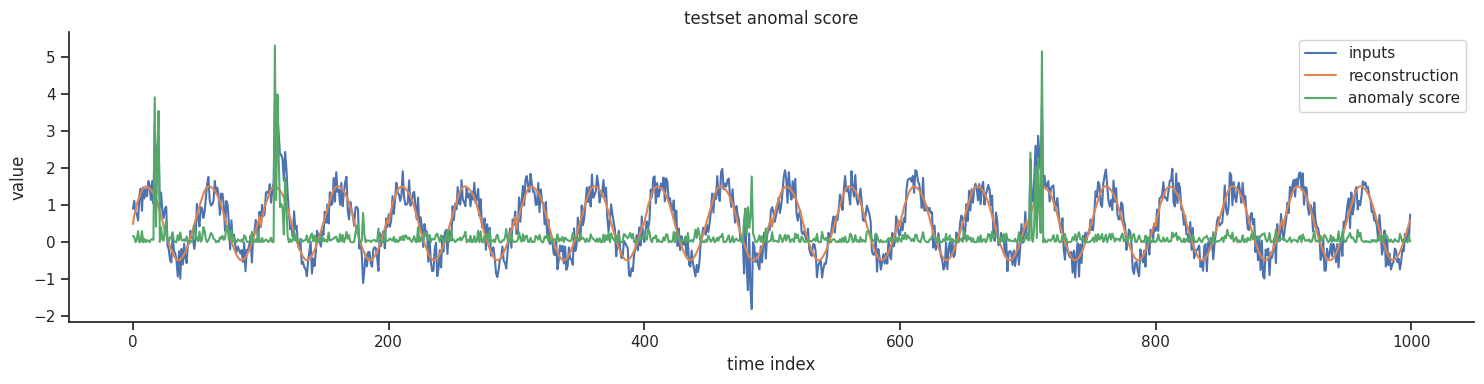


Epoch: [16/20]
TRAIN [    1/   37] loss: 0.1030
TRAIN [   37/   37] loss: 0.0931
TSET  [    1/    1] loss: 0.1360

Test AUROC: 0.8173


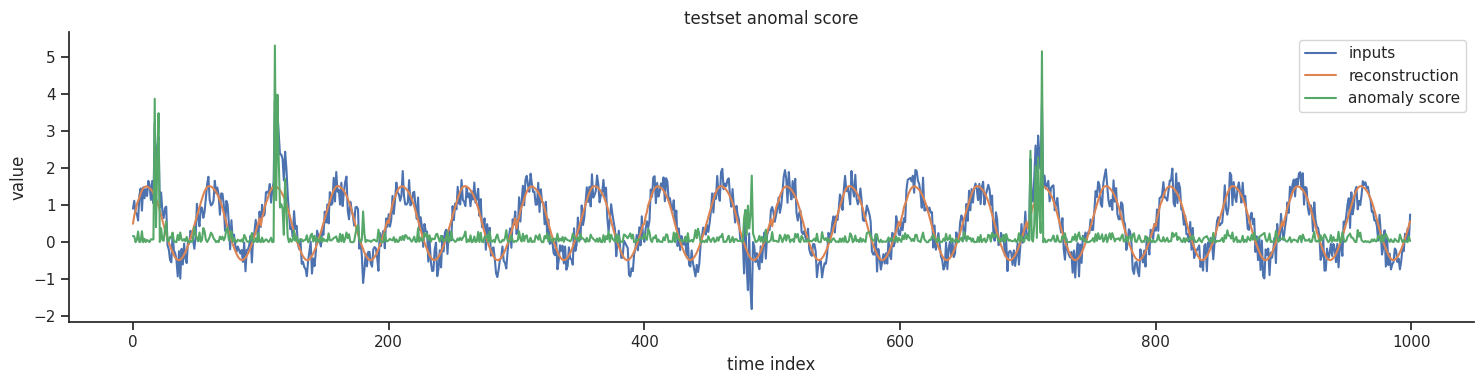


Epoch: [17/20]
TRAIN [    1/   37] loss: 0.1017
TRAIN [   37/   37] loss: 0.0925
TSET  [    1/    1] loss: 0.1346

Test AUROC: 0.8177


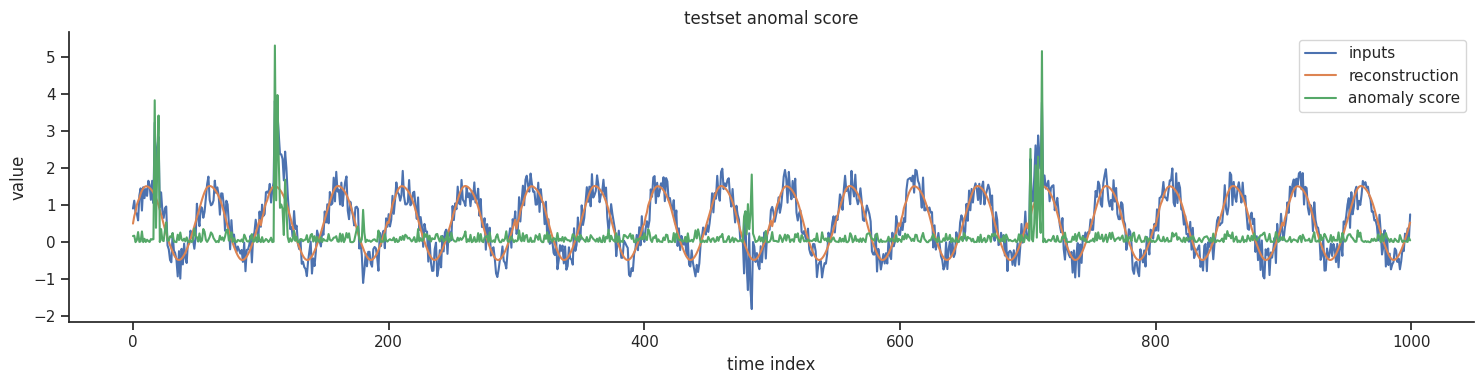


Epoch: [18/20]
TRAIN [    1/   37] loss: 0.1008
TRAIN [   37/   37] loss: 0.0924
TSET  [    1/    1] loss: 0.1340

Test AUROC: 0.8184


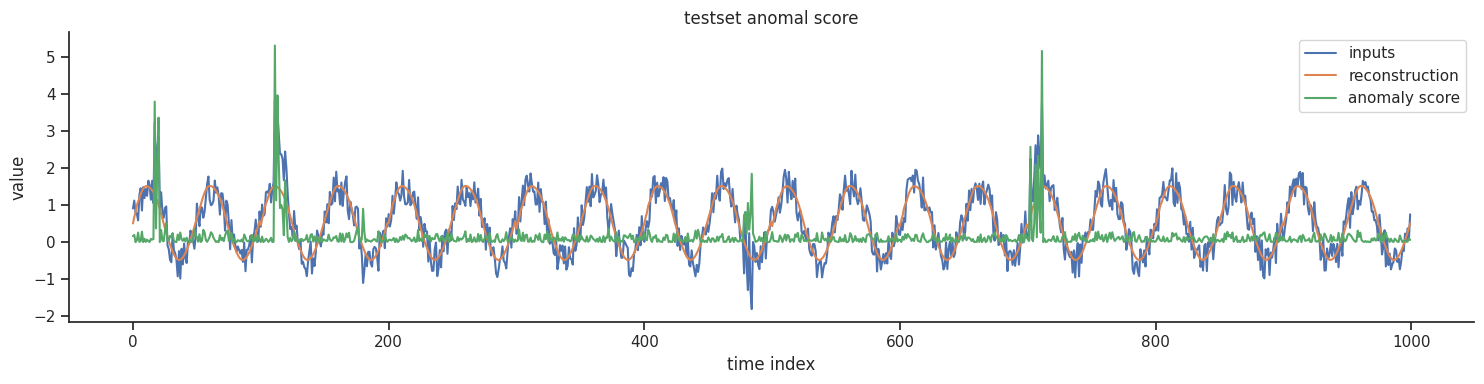


Epoch: [19/20]
TRAIN [    1/   37] loss: 0.1005
TRAIN [   37/   37] loss: 0.0924
TSET  [    1/    1] loss: 0.1339

Test AUROC: 0.8189


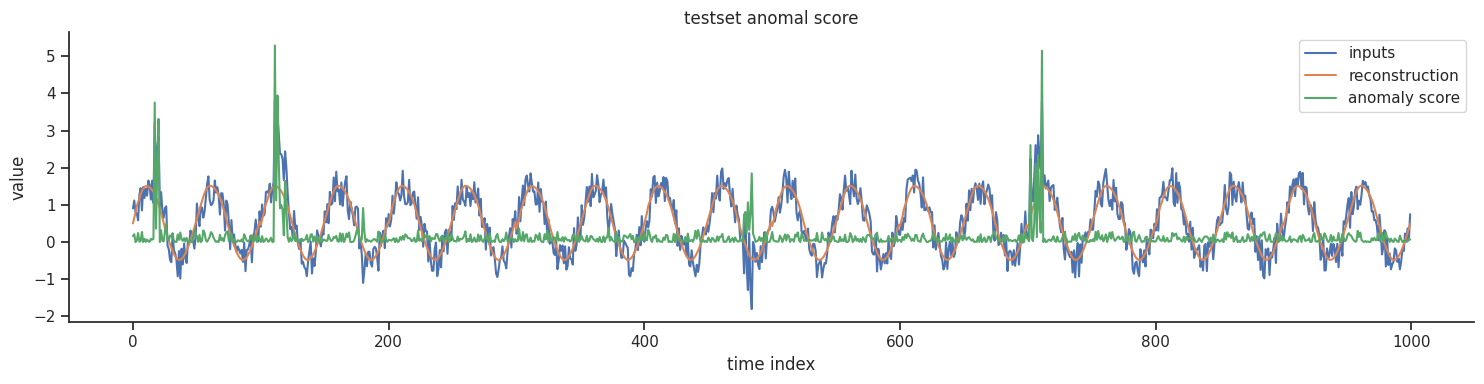


Epoch: [20/20]
TRAIN [    1/   37] loss: 0.1003
TRAIN [   37/   37] loss: 0.0924
TSET  [    1/    1] loss: 0.1339

Test AUROC: 0.8189


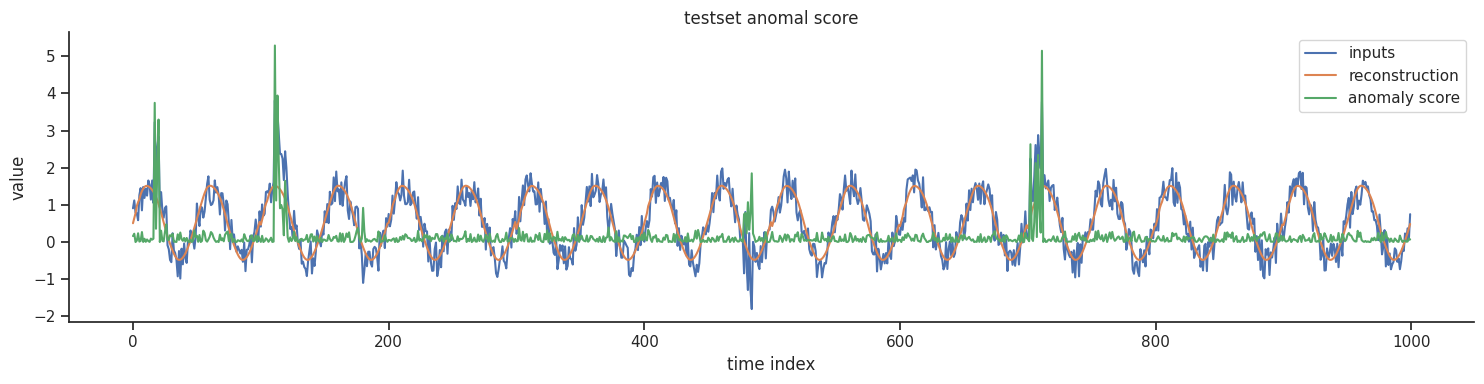

Training completed.


In [10]:
# 시드 설정
torch_seed(cfg.seed)

# RNNAutoEncoder 모델 학습 및 평가
train_history_rae, test_history_auroc_rae = fit(
    model=rae,                  # 학습할 모델
    trainloader=trainloader,    # 학습 데이터 로더
    testloader=testloader,      # 테스트 데이터 로더
    criterion=criterion,        # 손실 함수
    optimizer=optimizer,        # 옵티마이저
    epochs=cfg.epochs,          # 학습 에폭 수
    log_interval=cfg.log_interval,  # 로그 출력 간격
    device=cfg.device           # 학습에 사용할 디바이스
)

print("Training completed.")

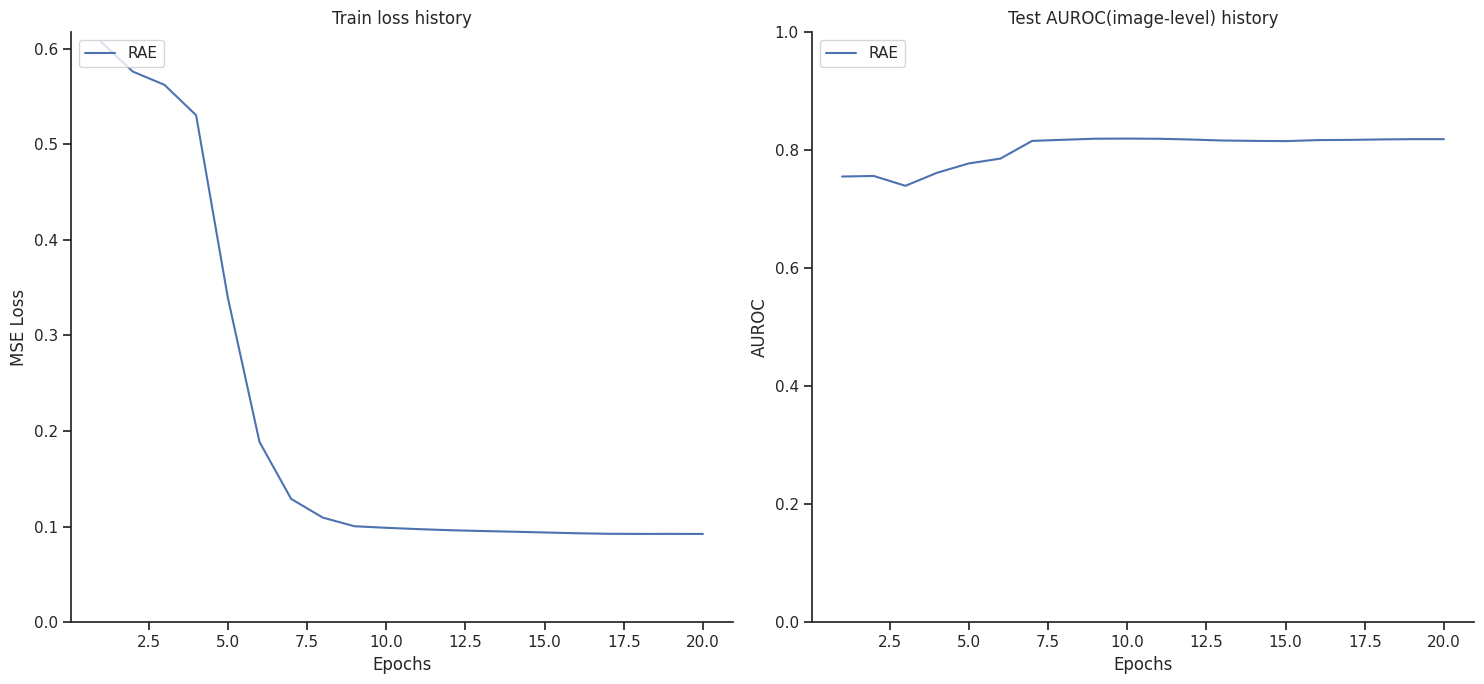

In [11]:
# 학습 및 평가 히스토리 리스트 정의
all_train_history = [train_history_rae]
all_test_history_auroc = [test_history_auroc_rae]
all_exp_name = ['RAE']

# 학습 및 평가 히스토리 시각화
figure(
    all_train_history=all_train_history,          # 모든 학습 손실 히스토리 리스트
    all_test_history_auroc=all_test_history_auroc,  # 모든 테스트 AUROC 히스토리 리스트
    all_exp_name=all_exp_name  # 모든 실험 이름 리스트
)

# Visualization

In [13]:
# 학습 데이터셋 정의
trainset = TSADDataset(
    X=x_train,         # 학습 입력 데이터
    y=y_train,         # 학습 타겟 레이블
    window=cfg.window, # 윈도우 크기
    stride=cfg.window  # 스트라이드 크기 (이 설정으로 전체 윈도우가 겹치지 않음)
)

# 학습 데이터로더 정의
trainloader = DataLoader(
    trainset,                      # 학습 데이터셋
    batch_size=cfg.batch_size,     # 배치 크기
    shuffle=False,                 # 데이터 순서 섞지 않기
    num_workers=cfg.num_workers    # 데이터 로딩을 위한 워커 수
)

TSET  [    1/    4] loss: 0.0870
TSET  [    4/    4] loss: 0.0876


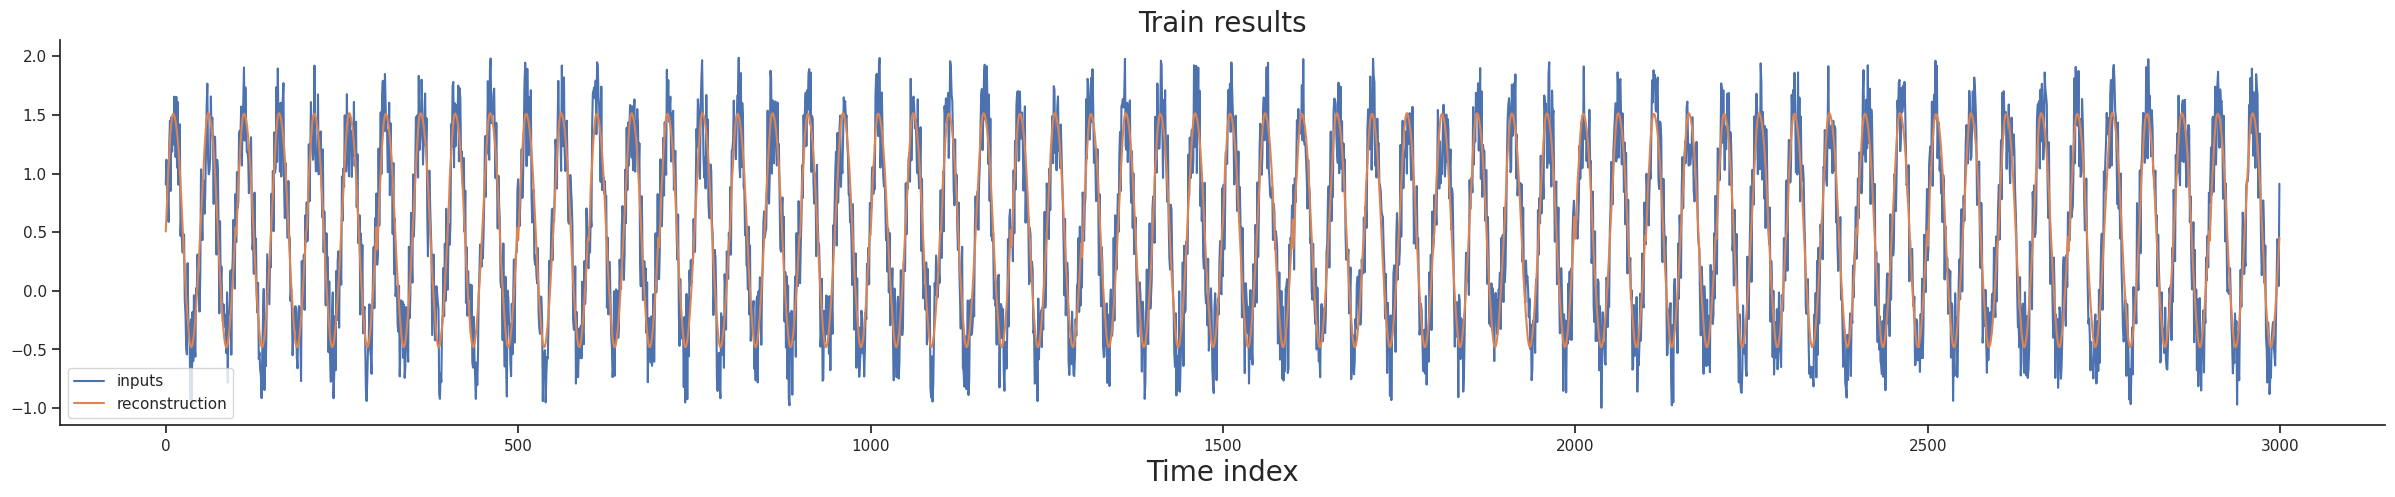

In [14]:
# 학습 데이터에 대한 모델 평가
_, total_inputs, total_outputs, total_loss = test(
    model=rae,                    # 평가할 모델
    dataloader=trainloader,       # 학습 데이터 로더
    criterion=criterion,          # 손실 함수
    log_interval=cfg.log_interval, # 로그 출력 간격
    device=cfg.device             # 평가에 사용할 디바이스
)

# 결과 시각화
fig, ax = plt.subplots(figsize=(30, 5))

# 입력 데이터 시각화
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:, 0], label='inputs', ax=ax)

# 재구성된 출력 데이터 시각화
sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:, 0], label='reconstruction', ax=ax)

# 그래프 제목 및 레이블 설정
ax.set_title('Train results', size=20)
ax.set_xlabel('Time index', size=20)

# 그래프 출력
plt.show()

In [15]:
def anomaly_region(anomaly_score, threshold):
    """
    이상치 점수를 기반으로 이상치 영역의 시작과 끝 인덱스를 계산하는 함수
    :param anomaly_score: 이상치 점수 배열
    :param threshold: 이상치로 간주할 임계값
    :return: 시작 인덱스 리스트와 끝 인덱스 리스트
    """
    # 이상치 점수가 임계값을 초과하는지 여부를 그룹화하여 누적 합 계산
    indices = list(accumulate(len(list(g)) for i, g in groupby((anomaly_score > threshold))))

    # 시작 인덱스 계산 (이상치가 True에서 False로 바뀌는 지점)
    starts = indices[:len(indices) // 2 * 2: 2]

    # 끝 인덱스 계산 (이상치가 False에서 True로 바뀌는 지점)
    stops = [i - 1 for i in indices[1::2]]

    return starts, stops

TSET  [    1/    1] loss: 0.1339


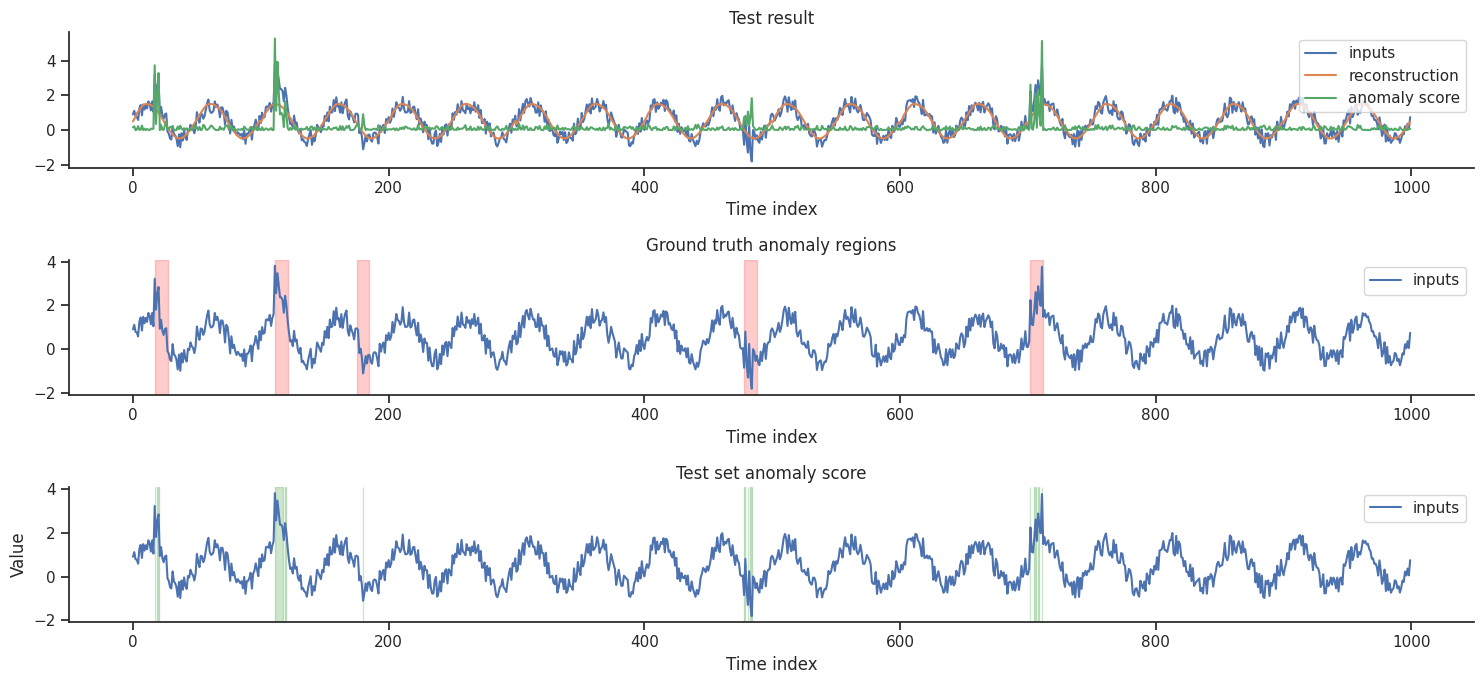

In [16]:
# 테스트 데이터에 대한 모델 평가
_, total_inputs, total_outputs, total_loss = test(
    model=rae,                    # 평가할 모델
    dataloader=testloader,        # 테스트 데이터 로더
    criterion=criterion,          # 손실 함수
    log_interval=cfg.log_interval, # 로그 출력 간격
    device=cfg.device             # 평가에 사용할 디바이스
)

# 결과 시각화
fig, ax = plt.subplots(3, 1, figsize=(15, 7))

# 입력 데이터, 재구성된 출력 데이터, 이상치 점수 시각화
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:, 0], label='inputs', ax=ax[0])
sns.lineplot(x=range(len(total_outputs)), y=total_outputs[:, 0], label='reconstruction', ax=ax[0])
sns.lineplot(x=range(len(total_loss)), y=total_loss, label='anomaly score', ax=ax[0])
ax[0].set_title('Test result')
ax[0].set_xlabel('Time index')

# Ground truth 이상치 영역 시각화
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:, 0], label='inputs', ax=ax[1])
for ano_idx in anomaly_idx:
    ax[1].axvspan(ano_idx, ano_idx + cfg.anomaly_sequence, color='red', alpha=0.2)
ax[1].set_title('Ground truth anomaly regions')
ax[1].set_xlabel('Time index')

# 예측된 이상치 영역 시각화
sns.lineplot(x=range(len(total_inputs)), y=total_inputs[:, 0], label='inputs', ax=ax[2])
starts, stops = anomaly_region(total_loss, threshold=0.5)
for start_idx, end_idx in zip(starts, stops):
    ax[2].axvspan(start_idx, end_idx, color='green', alpha=0.2)
ax[2].set_title('Prediction anomaly regions')
ax[2].set_xlabel('Time index')

# 그래프 제목 및 레이블 설정
plt.title("Test set anomaly score")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

---